# Experimental Results for Report

In [187]:
# This notebook runs from the projects root directory.
import os
PROJECT_ROOT_DIRECTORY = 'senior_project'
while os.path.basename(os.getcwd()) != PROJECT_ROOT_DIRECTORY:
    os.chdir(os.pardir)
print('Current working directory:', os.getcwd())

Current working directory: c:\Users\pavan\Desktop\senior_project


In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from stable_baselines3 import DQN
from environments.discrete_env_v2 import PortfolioManagementEnv

In [189]:
train_df = pd.read_csv('data\dow_10_stationary_features_train.csv', index_col=0, parse_dates=True)
val_df = pd.read_csv('data\dow_10_stationary_features_val.csv', index_col=0, parse_dates=True)
test_df = pd.read_csv('data\dow_10_stationary_features_test.csv', index_col=0, parse_dates=True)

TICKERS = ['AXP', 'AAPL', 'BA', 'GS', 'INTC', 'JNJ', 'KO', 'NKE', 'PG', 'DIS']
FEATURES = ['RETURN_12', 'RETURN_26', 'RETURN_60', 'STD_20']

RETURN_COLS = ['RISK_FREE'] + [ticker for ticker in TICKERS]
FEATURE_COLS = RETURN_COLS + [f'{ticker}_{feature}' for ticker in TICKERS for feature in FEATURES]

In [190]:
baselines = pd.read_csv('experiments/baselines_df.csv', index_col=0, parse_dates=True)
baselines_train = baselines.loc[train_df.index]
baselines_val = baselines.loc[val_df.index]
baselines_test = baselines.loc[test_df.index]

In [191]:
train_env = PortfolioManagementEnv(
    train_df, RETURN_COLS, FEATURE_COLS, window_size=10, episode_length=-1, drawdown_penalty_weight=1, allocations_in_obs=True
)

val_env = PortfolioManagementEnv(
    val_df, RETURN_COLS, FEATURE_COLS, window_size=10, episode_length=-1, drawdown_penalty_weight=1, allocations_in_obs=True
)

test_env = PortfolioManagementEnv(
    test_df, RETURN_COLS, FEATURE_COLS, window_size=10, episode_length=-1, drawdown_penalty_weight=1, allocations_in_obs=True
)

In [192]:
warnings.filterwarnings('ignore')
EXPERIMENT_ID = 'EXPERIMENT_6_1678606705'
MODEL_NUMBER = 260_000
model = DQN.load(f'experiments/models/{EXPERIMENT_ID}/{MODEL_NUMBER}')

### Train Dataset

In [193]:
obs, done = train_env.reset(), False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = train_env.step(action)
model_train = train_env.get_portfolio_returns()

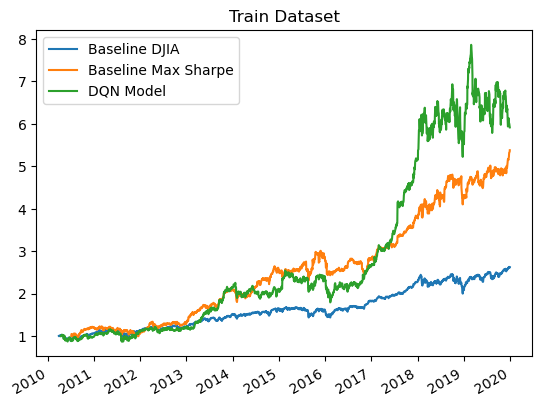

In [194]:
(1+baselines_train).cumprod().plot();
(1+model_train).cumprod().plot(label='DQN Model');
plt.title('Train Dataset');
plt.legend();

### Validation Dataset

In [195]:
obs, done = val_env.reset(), False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = val_env.step(action)
model_val = val_env.get_portfolio_returns()

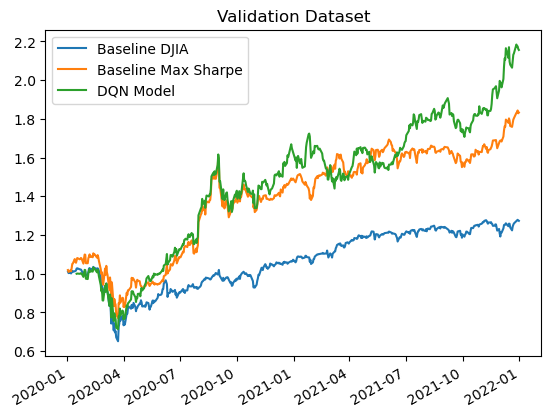

In [196]:
(1+baselines_val).cumprod().plot();
(1+model_val).cumprod().plot(label='DQN Model');
plt.title('Validation Dataset');
plt.legend();

### Test Dataset

In [197]:
obs, done = test_env.reset(), False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = test_env.step(action)
model_test = test_env.get_portfolio_returns()

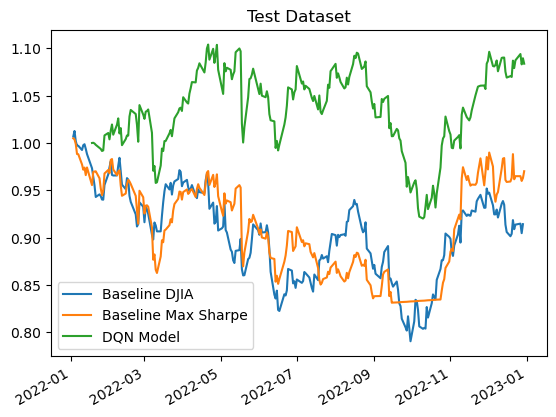

In [198]:
(1+baselines_test).cumprod().plot();
(1+model_test).cumprod().plot(label='DQN Model');
plt.title('Test Dataset');
plt.legend();

### Table Comparison

In [222]:
def create_results_table(column_names, returns_list):
    results_table = pd.DataFrame(columns=column_names)
    for column_name, returns in zip(column_names, returns_list):
        results_table.loc['Annualized Return (%)', column_name] = ((1+returns).prod()**(252/len(returns))-1)*100
        results_table.loc['Annualized Risk (%)', column_name] = ((returns.var()*252)**0.5)*100
        results_table.loc['Sharpe Ratio', column_name] = ((1+returns).prod()**(252/len(returns))-1) / ((returns.var()*252)**0.5)
    return results_table

In [230]:
print('Train Dataset')
create_results_table(
    column_names = ['DJIA', 'Max Sharpe Portfolio', 'DQN Model'],
    returns_list = [baselines_train['Baseline DJIA'], baselines_train['Baseline Max Sharpe'], model_train]
)

Train Dataset


,DJIA,Max Sharpe Portfolio,DQN Model
Annualized Return (%),10.379671,18.831647,20.088767
Annualized Risk (%),14.082372,17.776188,23.837066
Sharpe Ratio,0.737068,1.059375,0.842753


In [229]:
print('Validation Dataset')
create_results_table(
    column_names = ['DJIA', 'Max Sharpe Portfolio', 'DQN Model'],
    returns_list = [baselines_val['Baseline DJIA'], baselines_val['Baseline Max Sharpe'], model_val]
)

Validation Dataset


,DJIA,Max Sharpe Portfolio,DQN Model
Annualized Return (%),12.814079,35.302826,47.850268
Annualized Risk (%),27.432595,32.830452,35.954276
Sharpe Ratio,0.467111,1.075307,1.330864


In [228]:
print('Test Dataset')
create_results_table(
    column_names = ['DJIA', 'Max Sharpe Portfolio', 'DQN Model'],
    returns_list = [baselines_test['Baseline DJIA'], baselines_test['Baseline Max Sharpe'], model_test]
)

Test Dataset


,DJIA,Max Sharpe Portfolio,DQN Model
Annualized Return (%),-8.611766,-2.995794,8.773671
Annualized Risk (%),19.86207,19.530955,19.870434
Sharpe Ratio,-0.433578,-0.153387,0.441544
